In [37]:
import pandas as pd
import numpy as np
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [38]:
df = pd.read_csv("Housing.csv")

df["price_cat"] = pd.qcut(df["price"], q=3, labels=["Low", "Medium", "High"])

In [39]:
X = df[["area", "bedrooms"]].copy()
y = df["price_cat"]

In [40]:
X["area_cat"] = pd.qcut(X["area"], q=3, labels=["Small", "Medium", "Large"])
X["bed_cat"] = pd.cut(X["bedrooms"], bins=[0,2,4,10], labels=["Few", "Normal", "Many"])

X = X[["area_cat", "bed_cat"]]

In [41]:
def entropy(col):
    values, counts = np.unique(col, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum([p * log2(p) for p in probs])


In [42]:
def info_gain(data, feature, target):
    total_entropy = entropy(data[target])

    vals, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = 0

    for v, c in zip(vals, counts):
        subset = data[data[feature] == v]
        weighted_entropy += (c / len(data)) * entropy(subset[target])

    return total_entropy - weighted_entropy

In [43]:
def id3(data, features, target):

    if len(np.unique(data[target])) == 1:
        return np.unique(data[target])[0]

    if len(features) == 0:
        return data[target].mode()[0]

    gains = {f: info_gain(data, f, target) for f in features}
    best_feature = max(gains, key=gains.get)

    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]

    for value in np.unique(data[best_feature]):
        subset = data[data[best_feature] == value]

        if subset.empty:
            tree[best_feature][value] = data[target].mode()[0]
        else:
            tree[best_feature][value] = id3(subset, remaining_features, target)

    return tree


In [44]:
features = ["area_cat", "bed_cat"]
tree = id3(train_df, features, "price_cat")

print("\nGenerated ID3 Decision Tree:")
print(tree)


Generated ID3 Decision Tree:
{'area_cat': {'Large': {'bed_cat': {'Few': 'Medium', 'Many': 'High', 'Normal': 'High'}}, 'Medium': {'bed_cat': {'Few': 'Low', 'Many': 'High', 'Normal': 'Medium'}}, 'Small': {'bed_cat': {'Few': 'Low', 'Many': 'Low', 'Normal': 'Low'}}}}


In [45]:
def predict(tree, sample):
    for feature in tree.keys():
        value = sample[feature]

        if value in tree[feature]:
            next_node = tree[feature][value]

            if isinstance(next_node, dict):
                return predict(next_node, sample)
            else:
                return next_node
        else:
            return "Medium"

In [46]:
y_pred = []

for i in range(len(X_test)):
    y_pred.append(predict(tree, X_test.iloc[i]))

In [47]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6131386861313869

Confusion Matrix:
 [[32  4 16]
 [ 3 40 11]
 [ 7 12 12]]


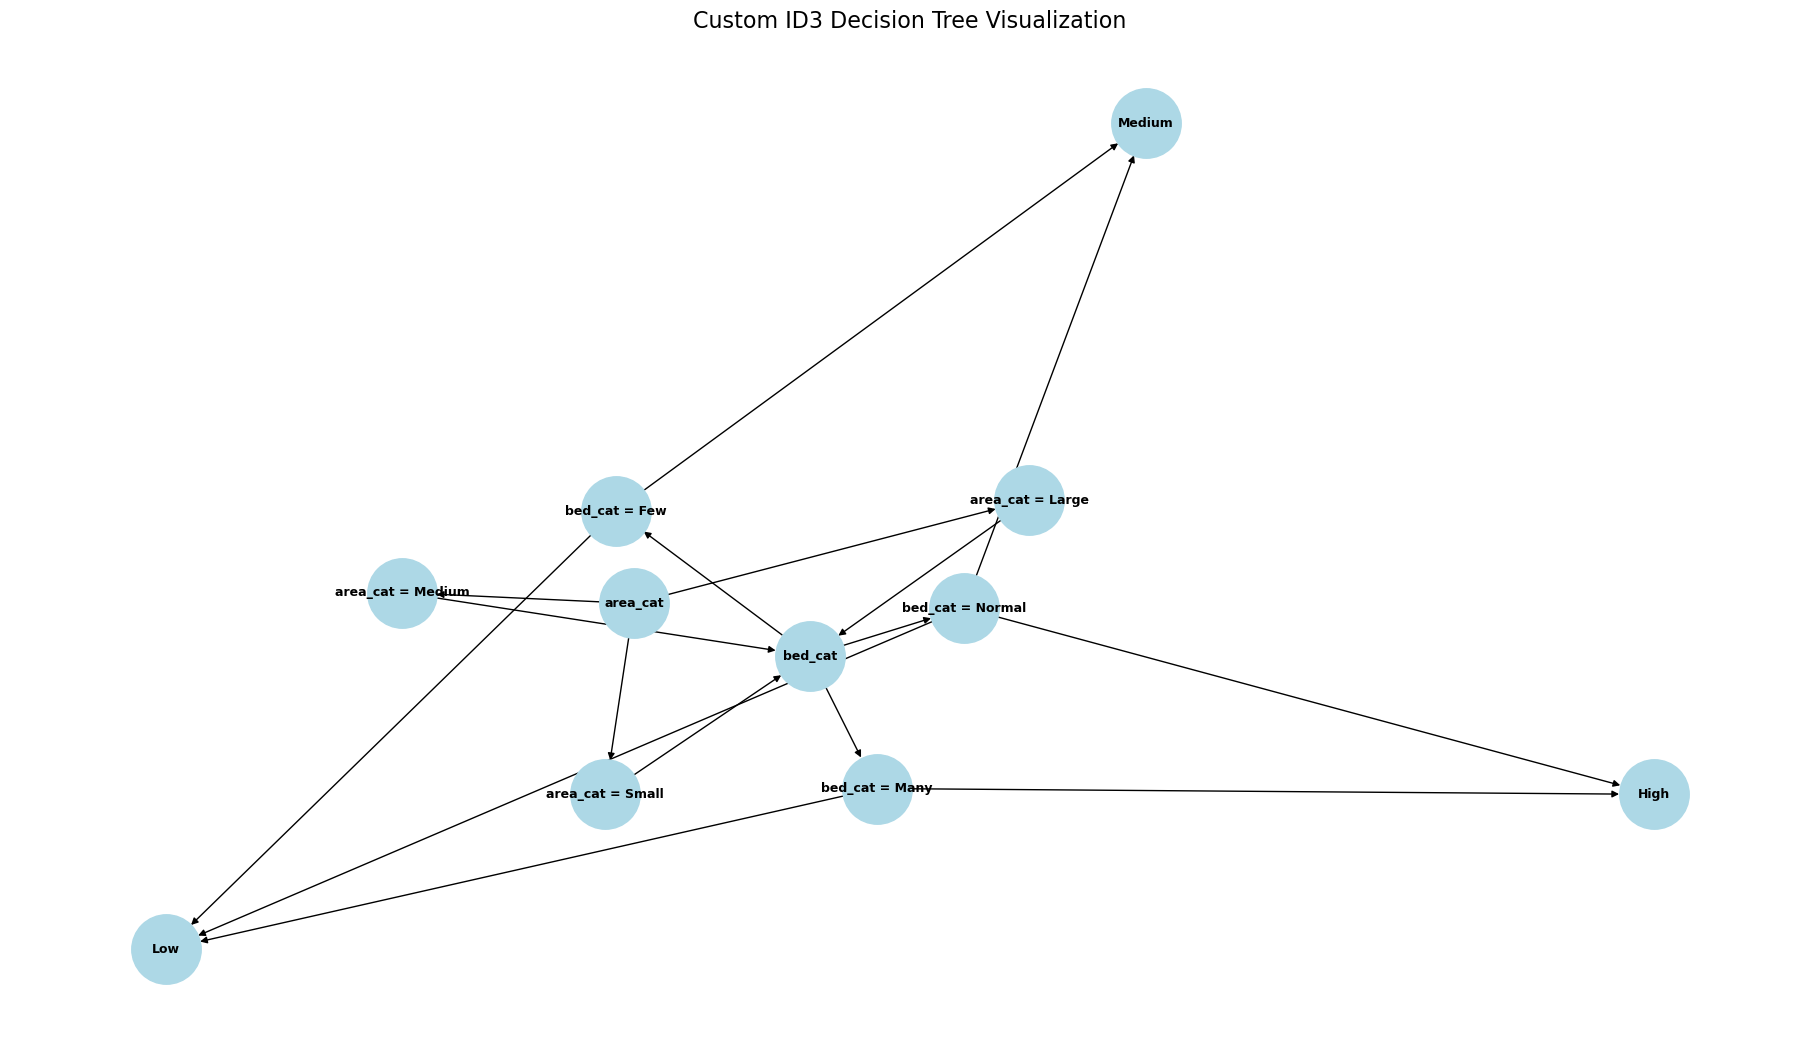

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

def add_edges(graph, tree, parent=None):
    if isinstance(tree, dict):
        for feature, branches in tree.items():
            if parent is not None:
                graph.add_edge(parent, feature)
            for value, subtree in branches.items():
                child_name = f"{feature} = {value}"
                graph.add_edge(feature, child_name)
                add_edges(graph, subtree, child_name)
    else:
        graph.add_edge(parent, tree)

G = nx.DiGraph()
add_edges(G, tree)

plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=2500,
    font_size=9,
    font_weight="bold",
    arrows=True,
    arrowstyle="-|>",
    linewidths=1
)
plt.title("Custom ID3 Decision Tree Visualization", fontsize=16)
plt.show()
